#  Entrenamiento de modelos, selección y deploy

## Importación de Librerías y Carga de Datos


In [ ]:
%pip install imblearn
%pip install ray
%pip install xgboost
%pip install pyathena
%pip install keras-tuner
%pip install tensorflow==2.12

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
INFO: pip is looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 585.9/585.9 MB 40.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 124.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 142.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 110.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 125.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 MB 136.6 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: wrapt
    F

In [ ]:
import time
import boto3
from pyathena import connect
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skew
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import ray
from ray import tune
from ray import air
from ray.tune import CLIReporter
from ray.tune import Tuner
from ray.tune.schedulers import HyperBandScheduler

In [ ]:
# Modelos
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import keras_tuner as kt
import tensorflow as tf
print(tf.__version__)

/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(
2024-11-25 21:01:24.004197: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-25 21:01:24.006604: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could 

2.12.0


In [ ]:
conn = connect(s3_staging_dir='s3://data-bucket-itba-delays/athena/', region_name='us-east-1')

df = pd.read_sql('SELECT * FROM dwh.flights_dataset', conn)

/tmp/ipykernel_21028/2650107578.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql('SELECT * FROM dwh.flights_dataset', conn)


## Exploración de Datos

In [ ]:
df.head().T

,0,1,2,3,4
month,6.000000,6.000000,4.000000,12.000000,9.000000
day_of_week,2.000000,6.000000,2.000000,1.000000,5.000000
dep_del15,1.000000,1.000000,0.000000,0.000000,1.000000
departing_airport_index,8.000000,6.000000,9.000000,10.000000,17.000000
previous_airport_index,15.000000,31.000000,14.000000,25.000000,0.000000
carrier_name_one_hot_1,0.000000,0.000000,0.000000,1.000000,0.000000
carrier_name_one_hot_2,0.000000,0.000000,0.000000,0.000000,0.000000
carrier_name_one_hot_3,0.000000,0.000000,0.000000,0.000000,0.000000
carrier_name_one_hot_4,1.000000,0.000000,0.000000,0.000000,1.000000
carrier_name_one_hot_5,0.000000,1.000000,0.000000,0.000000,0.000000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1297812 entries, 0 to 1297811
Data columns (total 42 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   month                    1297812 non-null  int64  
 1   day_of_week              1297812 non-null  int64  
 2   dep_del15                1297812 non-null  int64  
 3   departing_airport_index  1297812 non-null  float64
 4   previous_airport_index   1297812 non-null  float64
 5   carrier_name_one_hot_1   1297812 non-null  float64
 6   carrier_name_one_hot_2   1297812 non-null  float64
 7   carrier_name_one_hot_3   1297812 non-null  float64
 8   carrier_name_one_hot_4   1297812 non-null  float64
 9   carrier_name_one_hot_5   1297812 non-null  float64
 10  carrier_name_one_hot_6   1297812 non-null  float64
 11  carrier_name_one_hot_7   1297812 non-null  float64
 12  carrier_name_one_hot_8   1297812 non-null  float64
 13  carrier_name_one_hot_9   1297812 non-null 

In [ ]:
# Resumen estadístico de las columnas numéricas
df.describe().T

,count,mean,std,min,25%,50%,75%,max
month,1297812.0,6.609461,3.396736,1.000000,4.000000,7.000000,10.000000,12.000000
day_of_week,1297812.0,3.933427,1.994869,1.000000,2.000000,4.000000,6.000000,7.000000
dep_del15,1297812.0,0.189144,0.391624,0.000000,0.000000,0.000000,0.000000,1.000000
departing_airport_index,1297812.0,21.643544,20.935857,0.000000,5.000000,15.000000,32.000000,95.000000
previous_airport_index,1297812.0,32.717295,48.320701,0.000000,1.000000,15.000000,42.000000,354.000000
carrier_name_one_hot_1,1297812.0,0.200178,0.400133,0.000000,0.000000,0.000000,0.000000,1.000000
carrier_name_one_hot_2,1297812.0,0.144487,0.351583,0.000000,0.000000,0.000000,0.000000,1.000000
carrier_name_one_hot_3,1297812.0,0.139160,0.346113,0.000000,0.000000,0.000000,0.000000,1.000000
carrier_name_one_hot_4,1297812.0,0.092819,0.290179,0.000000,0.000000,0.000000,0.000000,1.000000
carrier_name_one_hot_5,1297812.0,0.089964,0.286130,0.000000,0.000000,0.000000,0.000000,1.000000


### Análisis variables categóricas

In [ ]:
# Identificar columnas categóricas
categorical_columns = df.select_dtypes(include=['object', 'category']).columns

# Generar una tabla separada de value_counts para cada columna categórica
for col in categorical_columns:
    print(f"Value counts for column: {col}")
    display(df[col].value_counts().reset_index().rename(columns={'index': col, col: 'Count'}))
    print("\n" + "="*100 + "\n")  # Separador entre tablas

### Análisis de valores nulos

In [ ]:
# Calcular el porcentaje de valores nulos por cada columna y filtrar solo las que tienen valores nulos
null_percent = df.isnull().mean() * 100
null_percent = null_percent[null_percent > 0].sort_values(ascending=False)

# Mostrar los resultados en formato de tabla
null_percent.to_frame(name='Percentage of Nulls (%)')

,Percentage of Nulls (%)


### Análisis de outliers

In [ ]:
# Función para calcular el porcentaje de outliers basado en el criterio de 1.5 IQR, solo para columnas con outliers
def calculate_outliers(df):
    outliers_percentage = {}
    numeric_columns = df.select_dtypes(include=['number']).columns

    for col in numeric_columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        outlier_percentage = 100 * len(outliers) / len(df)

        # Solo guardar si el porcentaje de outliers es mayor a cero
        if outlier_percentage > 0:
            outliers_percentage[col] = outlier_percentage

    # Convertir a DataFrame
    return pd.DataFrame.from_dict(outliers_percentage, orient='index', columns=['Outliers (%)']).sort_values(by='Outliers (%)', ascending=False)

# Aplicar la función y mostrar el porcentaje de outliers solo para columnas con outliers
calculate_outliers(df)

,Outliers (%)
scaled_features_15,20.776661
carrier_name_one_hot_1,20.017768
dep_del15,18.914450
carrier_name_one_hot_2,14.448703
carrier_name_one_hot_3,13.915960
carrier_name_one_hot_4,9.281930
carrier_name_one_hot_5,8.996372
previous_airport_index,7.981048
scaled_features_8,6.028146
scaled_features_7,5.888911


## Construcción de Modelos

En esta sección, construimos modelos de clasificación utilizando el conjunto de datos preparado.

- Selección de Algoritmos: Elegir algoritmos de clasificación adecuados (por ejemplo, Regresión Logística, Random Forest, SVM).
- Entrenamiento de Modelos: Entrenar modelos utilizando el conjunto de entrenamiento.
- Ajuste de Hiperparámetros: Ajustar hiperparámetros para optimizar el rendimiento de los modelos.

In [ ]:
semilla = 142857

In [ ]:
# X será todo menos la columna 'DEP_DEL15' (la target)
X = df.drop(columns=['dep_del15'])

# y será la columna 'DEP_DEL15' (la target)
y = df['dep_del15']

# Realizamos el split 70/30
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=semilla)

sm = SMOTE(sampling_strategy='auto', random_state=semilla)
X_train, y_train = sm.fit_resample(X_train, y_train)

# Verificamos el tamaño de los datos
print(f"Tamaño de X_train: {X_train.shape}")
print(f"Tamaño de X_test: {X_test.shape}")
print(f"Tamaño de y_train: {y_train.shape}")
print(f"Tamaño de y_test: {y_test.shape}")

Tamaño de X_train: (1474056, 41)
Tamaño de X_test: (389344, 41)
Tamaño de y_train: (1474056,)
Tamaño de y_test: (389344,)


In [ ]:
# Creo DF para ir guardando los resultados
column_names = ["Modelo", "Accuracy", "Precision", "Recall", "ROCAUC", "F1-Score", "Tiempo"]
resultados_df = pd.DataFrame(columns=column_names)

In [ ]:
# Función para guardar los resultados
def guardo_resultados(nombre_modelo, y_test, y_pred, tiempo_ejecucion):
    # Aquí calculamos las métricas de evaluación del modelo
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score

    # Calcular las métricas
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    rocauc = roc_auc_score(y_test, y_pred)

    # Crear un diccionario con los resultados
    resultados_dict = {
        'Modelo': [nombre_modelo],
        'Accuracy': [accuracy],
        'Precision': [precision],
        'Recall': [recall],
        'ROCAUC': [rocauc],
        'F1-Score': [f1],
        'Tiempo': [tiempo_ejecucion]
    }

    # Convertir el diccionario a un DataFrame
    resultados_df = pd.DataFrame(resultados_dict)

    return resultados_df

In [ ]:
def matriz_confusion(y_test, y_pred):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

    # Matriz de confusión sin normalizar
    conf_matrix = confusion_matrix(y_test, y_pred)
    sns.heatmap(conf_matrix,
                xticklabels=['En horario (P)', 'Retrasado (P)'],
                yticklabels=['En horario', 'Retrasado'],
                annot=True, fmt='d',
                ax=ax[0],
                square=True, linewidth=1)
    ax[0].set_title('Sin Normalizar')
    ax[0].set_xlabel('Predicción')
    ax[0].set_ylabel('Clase Verdadera')

    # Matriz de confusión normalizada
    conf_matrix_norm = conf_matrix.astype('float') / conf_matrix.sum()
    sns.heatmap(conf_matrix_norm,
                xticklabels=['En horario (P)', 'Retrasado (P)'],
                yticklabels=['En horario', 'Retrasado'],
                annot=True, fmt='.2%',
                ax=ax[1],
                square=True, linewidth=1)
    ax[1].set_title('Normalizada')
    ax[1].set_xlabel('Predicción')
    ax[1].set_ylabel('Clase Verdadera')

    # Título general
    plt.suptitle('Matriz de Confusión')
    plt.show()

In [ ]:
# Función para entrenar el modelo, guardar métricas y mostrar matriz de confusión
def entrenar_modelo(modelo, nombre_modelo, X_train, y_train, X_test, y_test, tf=False):
    # Entrenamos el modelo y medimos el tiempo de ejecución
    start = time.time()
    if tf:
        modelo.fit(X_train, y_train)
    else:
        modelo = modelo.fit(X_train, y_train)
    end = time.time()
    tiempo_ejecucion = end - start

    # Predecimos
    y_pred = modelo.predict(X_test) if not tf else np.where(modelo.predict(X_test) > 0.5, 1, 0)
    print(y_pred)
    print(y_pred.shape)

    # Guardamos los resultados en el DataFrame
    resultados = guardo_resultados(nombre_modelo, y_test, y_pred, tiempo_ejecucion)

    # Usamos pd.concat en lugar de append
    global resultados_df
    resultados_df = pd.concat([resultados_df, resultados], ignore_index=True)

    # Mostramos los resultados de este modelo
    print("Resultados para el modelo:", nombre_modelo)
    print(resultados)

    # Mostramos la matriz de confusión
    matriz_confusion(y_test, y_pred)

### Árbol de decisión

In [ ]:
modelo = DecisionTreeClassifier(
    criterion='entropy',
    max_depth=4,
    random_state=semilla)

[0 0 0 ... 0 0 1]
(389344,)
Resultados para el modelo: Árbol de decisión
              Modelo  Accuracy  Precision    Recall    ROCAUC  F1-Score  \
0  Árbol de decisión  0.746011   0.314274  0.284045  0.569262  0.298396   

      Tiempo  
0  12.129914  


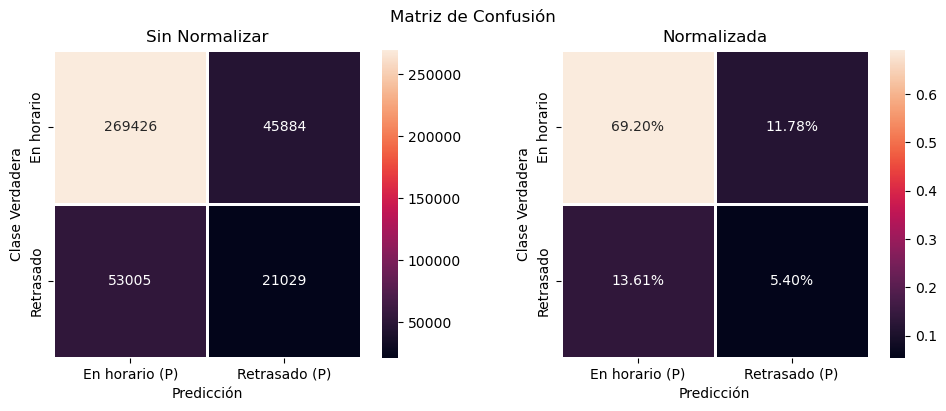

In [ ]:
entrenar_modelo(modelo, 'Árbol de decisión', X_train, y_train, X_test, y_test)

### Regresión Logística

In [ ]:
modelo = LogisticRegression(
    solver='liblinear',
    random_state=semilla)

[0 0 0 ... 0 0 1]
(389344,)
Resultados para el modelo: Regresión Logística
                Modelo  Accuracy  Precision    Recall    ROCAUC  F1-Score  \
0  Regresión Logística  0.615838   0.272154  0.609355  0.613358   0.37626   

      Tiempo  
0  67.674632  


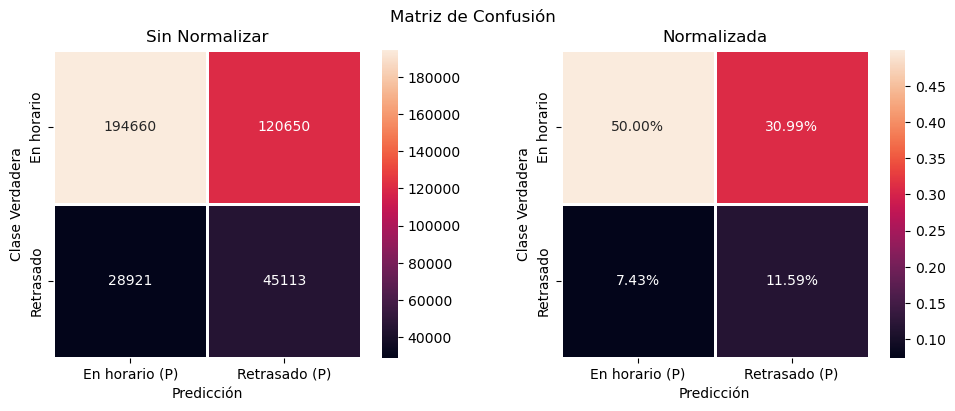

In [ ]:
entrenar_modelo(modelo, 'Regresión Logística', X_train, y_train, X_test, y_test)

### Random Forest

In [ ]:
modelo = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=semilla,
    class_weight='balanced'  # Si hay desbalance de clases
)

[0 0 0 ... 0 0 1]
(389344,)
Resultados para el modelo: Random Forest
          Modelo  Accuracy  Precision    Recall   ROCAUC  F1-Score      Tiempo
0  Random Forest  0.712989   0.320566  0.455021  0.61429  0.376139  261.929066


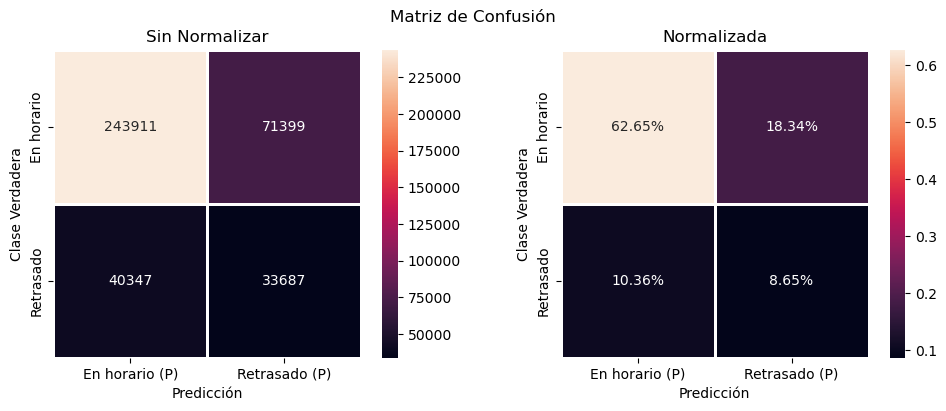

In [ ]:
entrenar_modelo(modelo, 'Random Forest', X_train, y_train, X_test, y_test)

### XGBoost

In [ ]:
modelo = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=42
)

[0 0 0 ... 0 0 0]
(389344,)
Resultados para el modelo: XGBoost
    Modelo  Accuracy  Precision    Recall    ROCAUC  F1-Score     Tiempo
0  XGBoost  0.805339   0.465354  0.159292  0.558161  0.237341  14.300134


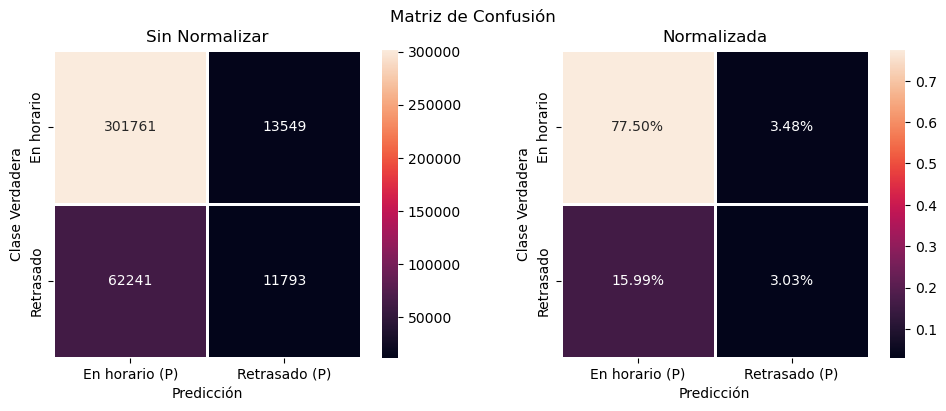

In [ ]:
entrenar_modelo(modelo, 'XGBoost', X_train, y_train, X_test, y_test)

### Red Neuronal

In [ ]:
modelo = tf.keras.Sequential([tf.keras.layers.Input(shape=(41,)),
                              tf.keras.layers.Dense(100, activation='relu'),
                              tf.keras.layers.Dense(100, activation='relu'),
                              tf.keras.layers.Dense(100, activation='relu'),
                              tf.keras.layers.Dense(100, activation='relu'),
                              tf.keras.layers.Dense(100, activation='relu'),
                              tf.keras.layers.Dense(1, activation='sigmoid')])
modelo.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['binary_crossentropy'])

2024-11-25 21:18:30.373865: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-25 21:18:30.667650: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


12167/12167 [==============================] - 9s 769us/step
[[0]
 [0]
 [0]
 ...
 [0]
 [1]
 [1]]
(389344, 1)
Resultados para el modelo: Red Neuronal
         Modelo  Accuracy  Precision    Recall    ROCAUC  F1-Score     Tiempo
0  Red Neuronal  0.689406   0.308711  0.511117  0.621192  0.384928  75.229409


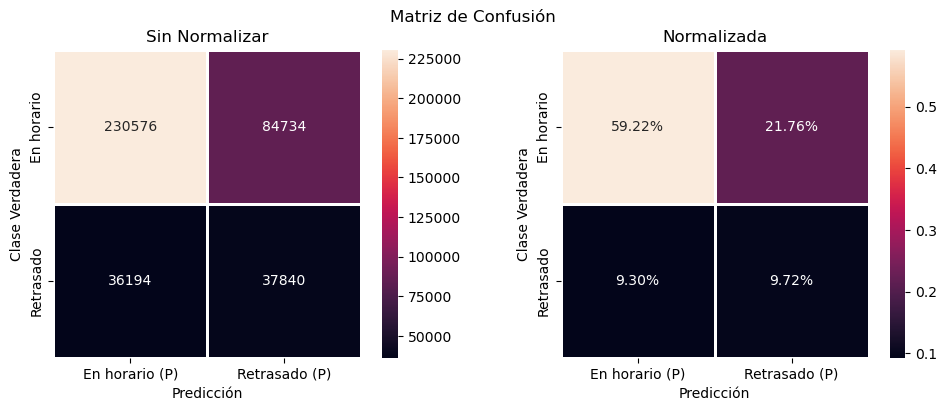

In [ ]:
entrenar_modelo(modelo, 'Red Neuronal', X_train, y_train, X_test, y_test, tf=True)

## Tuning

En esta sección, aplicamos técnicas de validación cruzada para evaluar la robustez de los modelos.

- Validación Cruzada K-Fold: Aplicar validación cruzada k-fold para evaluar el rendimiento de los modelos en múltiples divisiones de datos.
- Métricas de Evaluación: Calcular métricas de evaluación como precisión, recall, F1-score, matriz de confusión, ROC-AUC, etc.

### XGBoost

In [ ]:
data = {
    'X_train': X_train,
    'y_train': y_train
}

datasets = ray.put(data)

2024-11-25 21:20:02,944	INFO worker.py:1819 -- Started a local Ray instance.
(pid=3764) /home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
(pid=3764) Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
(pid=3764)   warnings.warn(
(pid=9950) /home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025*

In [ ]:
def XGB(config):
    data = ray.get(datasets)
    X_train = data['X_train']
    y_train = data['y_train']

    model = xgb.XGBClassifier(n_estimators=config['n_estimators'],
                              max_depth=config['max_depth'],
                              max_leaves=config['max_leaves'],
                              learning_rate=config['learning_rate'],
                              gamma=config['gamma'],
                              min_child_weight=config['min_child_weight'],
                              max_delta_step=config['max_delta_step'],
                              subsample=config['subsample'],
                              colsample_bytree=config['colsample_bytree'],
                              colsample_bylevel=config['colsample_bylevel'],
                              colsample_bynode=config['colsample_bynode'],
                              enable_categorical=config['enable_categorical'],
                              max_cat_to_onehot=config['max_cat_to_onehot'],
                              max_cat_threshold=config['max_cat_threshold'],
                              eval_metric='auc',
                              random_state=47)

    kfold = StratifiedKFold(n_splits=config['splits'], shuffle=True, random_state=47)

    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='roc_auc')

    ray.train.report(metrics={'auc': cv_results.mean()})

In [ ]:
config = {
    'n_estimators': tune.randint(500, 1500),
    'max_depth': tune.randint(20, 100),
    'max_leaves': tune.randint(0, 100),
    'learning_rate': tune.uniform(0.01, 0.5),
    'gamma': tune.randint(0, 5),
    'min_child_weight': tune.randint(1, 30),
    'max_delta_step': tune.randint(0, 30),
    'subsample': tune.uniform(0.8, 1.0),
    'colsample_bytree': tune.uniform(0.8, 1.0),
    'colsample_bylevel': tune.uniform(0.8, 1.0),
    'colsample_bynode': tune.uniform(0.8, 1.0),
    'enable_categorical': tune.choice([True, False]),
    'max_cat_to_onehot': tune.randint(100, 500),
    'max_cat_threshold': tune.randint(100, 500),
    'splits': tune.randint(3, 7)
}

In [ ]:
reporter = CLIReporter(
    metric='auc',
    mode='max'
)

hyperband = HyperBandScheduler(
    metric='auc',
    mode='max',
    max_t=5
)

tuner = Tuner(
    XGB,
    param_space=config,
    tune_config=tune.TuneConfig(num_samples=5, scheduler=hyperband),
    run_config=air.RunConfig(progress_reporter=reporter)
)

analysis = tuner.fit()

2024-11-25 21:20:04,107	INFO tune.py:616 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949
2024-11-25 21:20:04,115	INFO tensorboardx.py:193 -- pip install "ray[tune]" to see TensorBoard files.
2024-11-25 21:20:04,115	WARNING callback.py:136 -- The TensorboardX logger cannot be instantiated because either TensorboardX or one of it's dependencies is not installed. Please make sure you have the latest version of TensorboardX installed: `pip install -U tensorboardx`


== Status ==
Current time: 2024-11-25 21:20:04 (running for 00:00:00.15)
Using HyperBand: num_stopped=0 total_brackets=2
Round #0:
  Bracket(Max Size (n)=2, Milestone (r)=5, completed=0.0%): {PENDING: 2} 
  Bracket(Max Size (n)=3, Milestone (r)=1, completed=0.0%): {PENDING: 3} 
Logical resource usage: 0/4 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:T4)
Result logdir: /tmp/ray/session_2024-11-25_21-20-00_415179_21028/artifacts/2024-11-25_21-20-04/XGB_2024-11-25_21-20-04/driver_artifacts
Number of trials: 5/5 (5 PENDING)
+-----------------+----------+-------+---------------------+--------------------+--------------------+----------------------+---------+-----------------+---------------------+---------------------+------------------+-------------+--------------+--------------------+----------------+----------+-------------+
| Trial name      | status   | loc   |   colsample_bylevel |   colsample_bynode |   colsample_bytree | enable_categorical   |   gamma |   learning_rate |   max_cat_thres

2024-11-25 21:54:22,708	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/home/ec2-user/ray_results/XGB_2024-11-25_21-20-04' in 0.0051s.
2024-11-25 21:54:22,713	INFO tune.py:1041 -- Total run time: 2058.61 seconds (2058.58 seconds for the tuning loop).


== Status ==
Current time: 2024-11-25 21:54:22 (running for 00:34:18.59)
Using HyperBand: num_stopped=2 total_brackets=2
Round #0:
  Bracket(Max Size (n)=2, Milestone (r)=5, completed=100.0%): {TERMINATED: 2} 
  Bracket(Max Size (n)=1, Milestone (r)=3, completed=100.0%): {TERMINATED: 3} 
Logical resource usage: 1.0/4 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:T4)
Current best trial: 09860_00004 with auc=0.9356379872004086 and parameters={'n_estimators': 1117, 'max_depth': 90, 'max_leaves': 57, 'learning_rate': 0.3646416049228313, 'gamma': 0, 'min_child_weight': 11, 'max_delta_step': 1, 'subsample': 0.9804147003938432, 'colsample_bytree': 0.9457565867264207, 'colsample_bylevel': 0.9856966504943542, 'colsample_bynode': 0.8760341782678193, 'enable_categorical': True, 'max_cat_to_onehot': 222, 'max_cat_threshold': 156, 'splits': 5}
Result logdir: /tmp/ray/session_2024-11-25_21-20-00_415179_21028/artifacts/2024-11-25_21-20-04/XGB_2024-11-25_21-20-04/driver_artifacts
Number of trials: 5/5 (5 T

### Red Neuronal

In [ ]:
import keras_tuner as kt

def red_neuronal(hp):
    capas = hp.Int('capas', min_value=2, max_value=50, step=2)
    tamanio = hp.Int('tamanio', min_value=50, max_value=500, step=10)
    dropout_rate = hp.Float('dropout_rate', min_value=0.0, max_value=0.6, step=0.05)

    entrada = tf.keras.layers.Input(shape=(41,))

    for i in range(capas):
        medio = tf.keras.layers.Dense(tamanio, activation='leaky_relu', kernel_initializer='he_normal')
        bn = tf.keras.layers.BatchNormalization()
        do = tf.keras.layers.Dropout(dropout_rate)

        x = do(medio(bn(x))) if i != 0 else do(medio(bn(entrada)))

    salida = tf.keras.layers.Dense(1, activation='sigmoid')

    x = salida(x)

    modelo = tf.keras.Model(inputs=[entrada], outputs=[x])
    opt = tf.keras.optimizers.Nadam(learning_rate=hp.Float('learning_rate', min_value=0.00001, max_value=0.01, step=0.00001))

    modelo.compile(loss='binary_crossentropy', optimizer=opt, metrics=[tf.keras.metrics.AUC()])

    return modelo

In [ ]:
tuner = kt.BayesianOptimization(hypermodel=red_neuronal,
                                objective=kt.Objective('val_auc', direction='max'),
                                max_trials=2,
                                max_retries_per_trial=0,
                                max_consecutive_failed_trials=2,
                                overwrite=True,
                                project_name='Vuelos',
                                seed=47)

rlr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=0.00001)
es = tf.keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)

tuner.search(X_train, y_train, batch_size=64, validation_data=(X_test, y_test), callbacks=[es, rlr], epochs=1000)

mejormodelo = tuner.get_best_models(num_models=1)[0]

Trial 2 Complete [00h 33m 55s]
val_auc: 0.677888810634613

Best val_auc So Far: 0.677888810634613
Total elapsed time: 00h 59m 14s


## Selección del Modelo Final

En esta sección, seleccionamos el modelo de clasificación final que mejor se ajusta a nuestros datos y objetivos.

- Comparación de Modelos: Comparar el rendimiento de diferentes modelos.
- Elección del Modelo Final: Seleccionar el modelo con el mejor rendimiento en función de las métricas de evaluación.

In [ ]:
%pip install sagemaker
import sagemaker
import os
import tarfile

from sagemaker import get_execution_role
from sagemaker.tensorflow import TensorFlowModel

role = get_execution_role()
print("El rol de ejecución asociado es:", role)

bucket_name = 'data-bucket-itba-delays'
model_key = 'models/trained-model.tar.gz'
model_s3_path = f's3://{bucket_name}/{model_key}'

saved_model_dir = './saved_model/1'
mejormodelo.save(saved_model_dir, save_format='tf')
print(f"Modelo guardado en formato SavedModel en {saved_model_dir}")


tar_model_path = './saved-model.tar.gz'
with tarfile.open(tar_model_path, "w:gz") as tar:
    tar.add(saved_model_dir, arcname='saved_model/1')
print(f"Modelo comprimido en {tar_model_path}")


s3 = boto3.client('s3')
s3.upload_file(tar_model_path, bucket_name, model_key)
print(f"Modelo guardado en S3 en: {model_s3_path}")

tensorflow_model = TensorFlowModel(
    model_data=model_s3_path,
    role=role,
    framework_version='2.12.0',
    sagemaker_session=sagemaker.Session()
)

predictor = tensorflow_model.deploy(
    initial_instance_count=1,
    instance_type='ml.m5.xlarge'
)

print("Modelo desplegado con éxito en el endpoint de SageMaker.")

Note: you may need to restart the kernel to use updated packages.
El rol de ejecución asociado es: arn:aws:iam::562092036643:role/SMRole


2024-11-26 03:35:37.114287: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,500]
	 [[{{node inputs}}]]
2024-11-26 03:35:37.127759: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,500]
	 [[{{node inputs}}]]
2024-11-26 03:35:37.142064: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,500]
	 [[{{node inputs}}]]
2024-11-26 03:35

INFO:tensorflow:Assets written to: ./saved_model/1/assets


INFO:tensorflow:Assets written to: ./saved_model/1/assets


Modelo guardado en formato SavedModel en ./saved_model/1
Modelo comprimido en ./saved-model.tar.gz
Modelo guardado en S3 en: s3://data-bucket-itba-delays/models/trained-model.tar.gz
-----!Modelo desplegado con éxito en el endpoint de SageMaker.


TypeError: Object of type DataFrame is not JSON serializable

In [ ]:
import os
import tarfile
import boto3
from ray.tune import Analysis
from sagemaker import get_execution_role, Session
from sagemaker.xgboost import XGBoostModel
import xgboost as xgb

analysis_2 = tuner.fit()

best_trial = analysis.get_best_trial(metric="auc", mode="max")

print("Mejor Trial:", best_trial)

best_checkpoint = best_trial.checkpoint
print(f"Checkpoint del mejor modelo: {best_checkpoint}")

best_model = best_checkpoint.to_permanent()

model_path = './best_model.xgb'
best_model.save_model(model_path)
print(f"Modelo guardado en: {model_path}")

saved_model_dir = './xgboost_model/1'
os.makedirs(saved_model_dir, exist_ok=True)

os.rename(model_path, os.path.join(saved_model_dir, "model.xgb"))

tar_model_path = './xgboost-model.tar.gz'
with tarfile.open(tar_model_path, "w:gz") as tar:
    tar.add(saved_model_dir, arcname="xgboost_model/1")
print(f"Modelo comprimido en: {tar_model_path}")

bucket_name = 'data-bucket-itba-delays'
model_key = 'models/xgboost-trained-model.tar.gz'
model_s3_path = f's3://{bucket_name}/{model_key}'

s3 = boto3.client('s3')
s3.upload_file(tar_model_path, bucket_name, model_key)
print(f"Modelo guardado en S3 en: {model_s3_path}")

role = get_execution_role()
session = Session()

xgboost_model = XGBoostModel(
    model_data=model_s3_path,
    role=role,
    framework_version="1.5-1",
    sagemaker_session=session
)

endpoint_name = "xgboost-endpoint"

predictor = xgboost_model.deploy(
    initial_instance_count=1,
    instance_type="ml.m5.large",
    endpoint_name=endpoint_name
)

print(f"Modelo desplegado en el endpoint: {endpoint_name}")